In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# 1.  **Data Preprocessing**

In [2]:
train_data = pd.read_csv(r"/kaggle/input/playground-series-s5e1/train.csv")
test_data = pd.read_csv(r"/kaggle/input/playground-series-s5e1/test.csv")
sample_submission = pd.read_csv(r"/kaggle/input/playground-series-s5e1/sample_submission.csv")

print("train_data shape :",train_data.shape)
print("test_data shape :",test_data.shape)
print("sample_submission shape :",sample_submission.shape)

train_data shape : (230130, 6)
test_data shape : (98550, 5)
sample_submission shape : (98550, 2)


In [3]:
print(train_data['date'].max())
print(train_data['date'].min())

2016-12-31
2010-01-01


In [4]:
print(test_data['date'].max())
print(test_data['date'].min())

2019-12-31
2017-01-01


* The training dataset for 7 years between 2010 and 2016
* The testing  dataset for 2 years between 2017 and 2019

  The expectation of the machnine learning model is to predict the sales of the upcoming years, hence this becomes a time series problem. The Dataset only has 3 columns ID, Date and Sales. Thus machine requires more data to work and predict. In the next cell we will split the date into its cyclic format, this makes it easier for the machine to know the various differences in time periods.

In [5]:
import pandas as pd
import numpy as np

def date_feature_engineering(df):

    """
    Function to improve the data on the given date of sale.

    
    Args: Dataframe containing a date column
    
    Returns: Converted dataframe with additional features on the date column
    """
    df['date'] = pd.to_datetime(df['date'])
    df['year']= df['date'].dt.year
    df['month']= df['date'].dt.month
    df['day']= df['date'].dt.day
    df['day_of_week']= df['date'].dt.day_name()

    # cyclic functions on day,month,year aka day_sin/day_cos

    # X[f"{variable}_sin"] = np.sin(X["variable"] * (2.0 * np.pi / X["variable"]).max())
    # X[f"{variable}_cos"] = np.cos(X["variable"] * (2.0 * np.pi / X["variable"]).max())
    #  For example, In the case of days to convert into sin then formula will change accordingly below
    # df[day_sin] = np.sin(df['day'] * 2 * np.pi / max(days))
    #  here max(days) = 365 days in a year
    
    df['day_sin'] = np.sin(2 * np.pi * df['day']/365.0)    
    df['day_sin'] = np.cos(2 * np.pi * df['day']/365.0)    
    df['month_sin']=np.sin(2* np.pi * df['month']/12.0)
    df['month_cos']=np.cos(2* np.pi * df['month']/12.0)

    # Data is between the years 2010 to 2016 with 7 years
    
    df['year_sin']=np.sin(2* np.pi * df['year']/7.0)
    df['year_cos']=np.cos(2* np.pi * df['year']/7.0)
    
    return df

In [6]:
train_data = date_feature_engineering(train_data)
test_data = date_feature_engineering(test_data)

train_data

,id,date,country,store,product,num_sold,year,month,day,day_of_week,day_sin,month_sin,month_cos,year_sin,year_cos
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,2010,1,1,Friday,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,2010,1,1,Friday,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,2010,1,1,Friday,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,2010,1,1,Friday,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,2010,1,1,Friday,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0,2016,12,31,Saturday,0.860961,-2.449294e-16,1.000000,-7.053966e-14,1.00000
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0,2016,12,31,Saturday,0.860961,-2.449294e-16,1.000000,-7.053966e-14,1.00000
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0,2016,12,31,Saturday,0.860961,-2.449294e-16,1.000000,-7.053966e-14,1.00000
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0,2016,12,31,Saturday,0.860961,-2.449294e-16,1.000000,-7.053966e-14,1.00000


# 2. Exploratory Data Analysis EDA

Looking though the data to identify the various combinations of stickers sold and its relationships to various important days of the calendar.

In [7]:
df = train_data.copy()
df['is_weekend'] = train_data['day_of_week'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)
df

,id,date,country,store,product,num_sold,year,month,day,day_of_week,day_sin,month_sin,month_cos,year_sin,year_cos,is_weekend
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,2010,1,1,Friday,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349,0
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,2010,1,1,Friday,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349,0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,2010,1,1,Friday,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349,0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,2010,1,1,Friday,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349,0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,2010,1,1,Friday,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0,2016,12,31,Saturday,0.860961,-2.449294e-16,1.000000,-7.053966e-14,1.00000,1
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0,2016,12,31,Saturday,0.860961,-2.449294e-16,1.000000,-7.053966e-14,1.00000,1
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0,2016,12,31,Saturday,0.860961,-2.449294e-16,1.000000,-7.053966e-14,1.00000,1
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0,2016,12,31,Saturday,0.860961,-2.449294e-16,1.000000,-7.053966e-14,1.00000,1


<Axes: xlabel='is_weekend', ylabel='num_sold'>

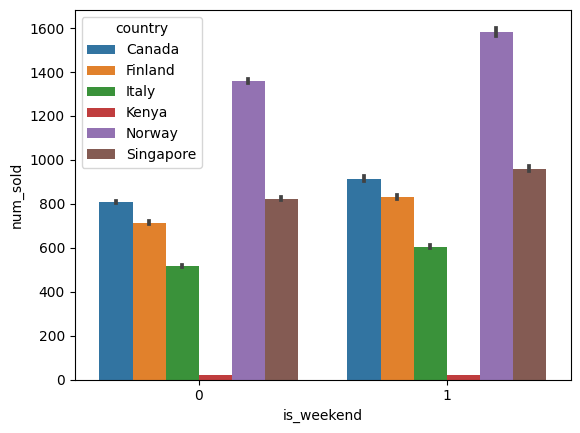

In [8]:
# Weekday sales vs Weekend sales

sns.barplot(data=df, x='is_weekend', y='num_sold', hue='country')

<Axes: xlabel='country', ylabel='num_sold'>

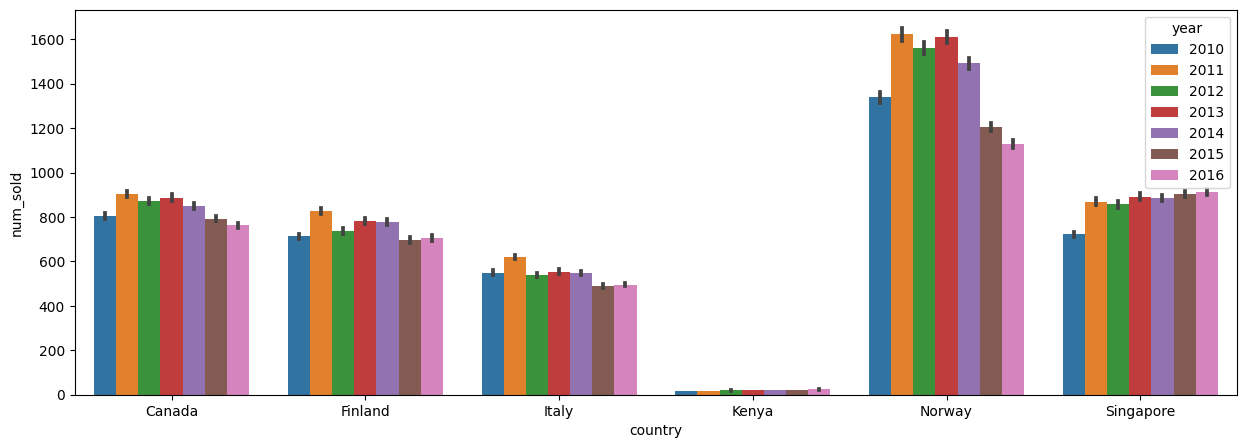

In [9]:
# Country sales

plt.figure(figsize=(15,5))
sns.barplot(data=df, x='country', y='num_sold', hue='year')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='month', ylabel='num_sold'>

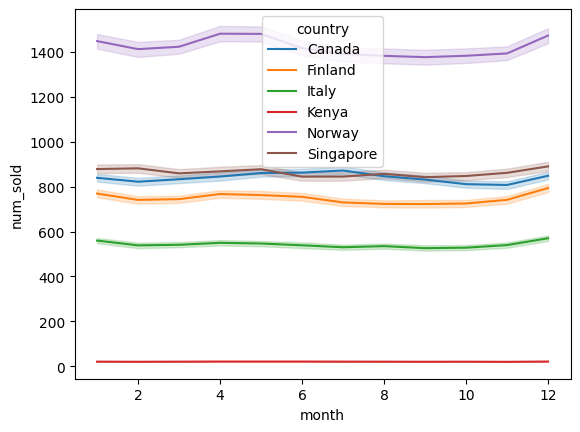

In [10]:
# month wise sales

sns.lineplot(data=df, x='month', y='num_sold', hue='country')

<Axes: xlabel='product', ylabel='num_sold'>

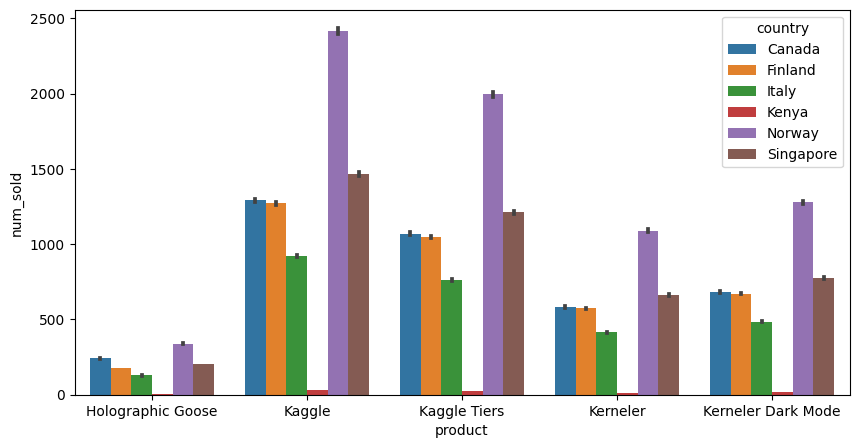

In [11]:
# product wise sales
plt.figure(figsize=(10,5))
sns.barplot(data=df, x='product', y='num_sold', hue='country')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


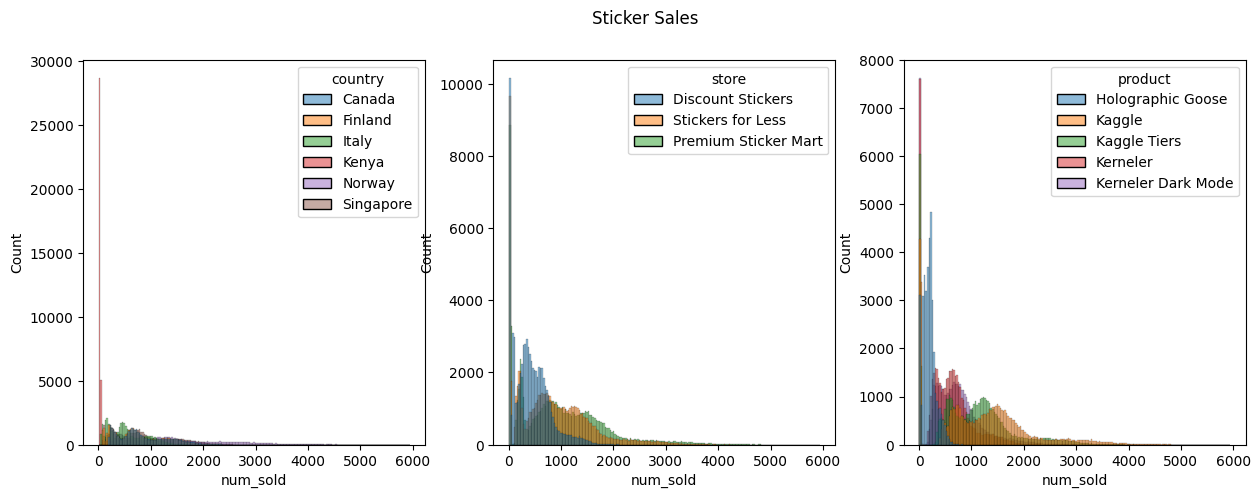

In [12]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))

plt.suptitle("Sticker Sales")
sns.histplot(data=df, x='num_sold', hue='country', ax=axes[0]);
sns.histplot(data=df, x='num_sold', hue='store', ax=axes[1]);
sns.histplot(data=df, x='num_sold', hue='product', ax=axes[2]);

# 3. Model Preparation

In [13]:
train_data.drop('date',axis=1,inplace=True)
test_data.drop('date',axis=1,inplace=True)

In [14]:
print("train data shape :", train_data.shape)
print("test data shape :", test_data.shape)

train data shape : (230130, 14)
test data shape : (98550, 13)


In [15]:
train_data['num_sold'] = np.log1p(train_data['num_sold'])

In [16]:
train_data = train_data.drop('id', axis = 1)

# split data based on int/float vs object types for encoding the object types 

num_cols = list(train_data.select_dtypes(exclude=['object']).columns.difference(['num_sold']))
cat_cols = list(train_data.select_dtypes(include=['object']).columns)

num_cols_test = list(test_data.select_dtypes(exclude=['object']).columns.difference(['id']))
cat_cols_test = list(test_data.select_dtypes(include=['object']).columns)

In [17]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Apply encoding for object datatype columns to convert into consecutive integers

label_encoders = {col: LabelEncoder() for col in cat_cols}
for col in cat_cols:
    train_data[col] = label_encoders[col].fit_transform(train_data[col])
    test_data[col] = label_encoders[col].transform(test_data[col])

In [18]:
train_data = train_data.dropna()
train_data.shape

(221259, 13)

In [19]:
from sklearn.model_selection import train_test_split

X = train_data.drop(['num_sold'], axis=1)
y = train_data['num_sold']
test = test_data.drop(['id'],axis=1)

X

,country,store,product,year,month,day,day_of_week,day_sin,month_sin,month_cos,year_sin,year_cos
1,0,0,1,2010,1,1,0,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349
2,0,0,2,2010,1,1,0,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349
3,0,0,3,2010,1,1,0,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349
4,0,0,4,2010,1,1,0,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349
5,0,2,0,2010,1,1,0,0.999852,5.000000e-01,0.866025,7.818315e-01,0.62349
...,...,...,...,...,...,...,...,...,...,...,...,...
230125,5,1,0,2016,12,31,2,0.860961,-2.449294e-16,1.000000,-7.053966e-14,1.00000
230126,5,1,1,2016,12,31,2,0.860961,-2.449294e-16,1.000000,-7.053966e-14,1.00000
230127,5,1,2,2016,12,31,2,0.860961,-2.449294e-16,1.000000,-7.053966e-14,1.00000
230128,5,1,3,2016,12,31,2,0.860961,-2.449294e-16,1.000000,-7.053966e-14,1.00000


In [20]:
# Taken from another notebook

parameters = {'n_estimators': 3946, 'learning_rate': 0.10203344298643195, 'max_depth': 12, 'num_leaves': 20, 'min_child_samples': 39, 'subsample': 0.7786665459484634, 'colsample_bytree': 0.7352055562065795, 'reg_alpha': 0.2840216195298897, 'reg_lambda': 6.583320975256993, "verbosity" : -1}

In [21]:
# Define MAPE metric
def mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)*100

# Cross-validation for LGBMRegressor
def cross_val_lgbm_mape(X, y, test, n_splits=7, **parameters):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mape_scores = []
    preds = []

    for train_index, valid_index in kf.split(X):

        # Split dataset into 7 parts for train and test
        
        # Ensure data types for indexing
        if isinstance(X, pd.DataFrame):
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        else:
            X_train, X_valid = X[train_index], X[valid_index]
            y_train, y_valid = y[train_index], y[valid_index]

        # Initialize and train the model
        model = LGBMRegressor(random_state=42, **parameters)
        model.fit(X_train, y_train)

        # Predictions and evaluation
        y_pred = model.predict(X_valid)
        score = mape(y_valid, y_pred)
        mape_scores.append(score)

        # Predict on the test set
        preds.append(model.predict(test))

    # Average predictions over all folds
    test_preds_mean = np.mean(preds, axis=0)

    return np.mean(mape_scores), test_preds_mean


average_mape, lgb_preds = cross_val_lgbm_mape(X, y, test, n_splits=7, **parameters)

print(f"Average MAPE across folds: {average_mape:.4f}")

# Save predictions for submission
# round is used since predications can come close the validation values
submission = pd.DataFrame({'id': test_data['id'], 'num_sold': np.expm1(lgb_preds).round()})
print(submission.head())
submission.to_csv('submission.csv', index=False)

Average MAPE across folds: 0.7868
       id  num_sold
0  230130     137.0
1  230131     830.0
2  230132     747.0
3  230133     380.0
4  230134     441.0
